<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Compare-against-PRECISE" data-toc-modified-id="Compare-against-PRECISE-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Compare against PRECISE</a></span><ul class="toc-item"><li><span><a href="#Identify-new-components" data-toc-modified-id="Identify-new-components-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify new components</a></span><ul class="toc-item"><li><span><a href="#Component-11" data-toc-modified-id="Component-11-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Component 11</a></span></li></ul></li><li><span><a href="#Investigate-component-weightings" data-toc-modified-id="Investigate-component-weightings-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Investigate component weightings</a></span></li></ul></li></ul></div>

**This notebook is only relevant if you are appending E. coli data to PRECISE**

# Setup

In [1]:
import sys
sys.path.append('../..')

from matplotlib_venn import venn2
import pandas as pd
from tqdm import tqdm_notebook as tqdm

from icaviz.plotting import *

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
DATA_DIR = '../../data/precise2_data/'
PRECISE_DIR = '../../data/precise_data/'
GENE_DIR = '../../data/annotation/'

In [4]:
component_info_df = pd.read_csv(DATA_DIR + 'component_info.csv', index_col=0)
precise2 = load_data(X=DATA_DIR+'log_tpm_qc.csv',
                     S=DATA_DIR+'S.csv',
                     A=DATA_DIR+'A.csv',
                     metadata=DATA_DIR+'metadata_qc.csv',
                     annotation=GENE_DIR+'gene_info.csv',
                     trn=GENE_DIR+'TRN.csv',
                     cutoff = 525, names=component_info_df['name']) # Get correct cut-off score from 3_estimate_thresholds

In [5]:
enrich = pd.read_csv(PRECISE_DIR+'curated_enrichments.csv')
names = enrich['name'].tolist()
precise = load_data(X=PRECISE_DIR+'log_tpm.csv',
                     S=PRECISE_DIR+'S.csv',
                     A=PRECISE_DIR+'A.csv',
                     metadata=PRECISE_DIR+'metadata.csv',
                     annotation=GENE_DIR+'gene_info.csv',
                     trn=GENE_DIR+'TRN.csv',
                     cutoff = 550,names=names)

## Automatically Create Raw Enrichments

This section only needs to be run once; if component_info.csv exists already in the data directory, then this automated initial step has been taken, and that file should be consulted for further manual annotation

In [6]:
dot,links = compare_ica(precise.S,precise2.S,cutoff=0.3)

In [7]:
component_info_df = pd.DataFrame(columns=[
    'component', 'name', 'TF', 'log_odds', 'f1score', 'pvalue',
    'precision', 'recall', 'TP', 'n_genes', 'n_tf', 'Regulator',
    'Function', 'Category', 'threshold', 'PRECISE_name'
])

for component_idx in tqdm(range(precise2.S.shape[1])):
    component_info_df.loc[component_idx, 'component'] = component_idx
    
    precise_idx_tup_listed = [tup for tup in links if int(tup[1]) == component_idx]
    if len(precise_idx_tup_listed) == 1:
        precise_name = precise_idx_tup_listed[0][0]
        component_info_df.loc[component_idx, 'PRECISE_name'] = precise_name
        precise_enrich_row = enrich[enrich['name'] == precise_name]
        component_info_df.loc[component_idx, 'Function'] = precise_enrich_row['Function'].values[0]
        component_info_df.loc[component_idx, 'Category'] = precise_enrich_row['Category'].values[0]
    
    component_info_df.loc[component_idx, 'threshold'] = precise2.thresholds[component_idx]
    
    genes = precise2.show_enriched(component_idx).index
    component_info_df.loc[component_idx, 'n_genes'] = len(genes)
    
    all_genes = precise2.X.index
    enrichment_df = compute_enrichments(genes, all_genes, precise2.trn, max_tfs = 1, fdr_rate=1e-5)
    if enrichment_df.shape[0] > 0:
        tf_name = enrichment_df.index[0]
        component_info_df.loc[component_idx, 'Regulator'] = tf_name
        component_info_df.loc[component_idx, 'log_odds'] = enrichment_df.loc[tf_name, 'log_odds']
        component_info_df.loc[component_idx, 'pvalue'] = enrichment_df.loc[tf_name, 'pvalue']
        component_info_df.loc[component_idx, 'recall'] = enrichment_df.loc[tf_name, 'recall']
        component_info_df.loc[component_idx, 'precision'] = enrichment_df.loc[tf_name, 'precision']
        component_info_df.loc[component_idx, 'TP'] = enrichment_df.loc[tf_name, 'TP']
        component_info_df.loc[component_idx, 'f1score'] = enrichment_df.loc[tf_name, 'f1score']
        component_info_df.loc[component_idx, 'n_tf'] = enrichment_df.loc[tf_name, 'n_tf']

/Users/cam/.virtualenvs/precise2/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [8]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
component_info_df

,component,name,TF,log_odds,f1score,pvalue,precision,recall,TP,n_genes,n_tf,Regulator,Function,Category,threshold,PRECISE_name
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,NaN,NaN,Nitric oxide response,Biological Enrichment,0.257489,nitrate-related
1,1,NaN,NaN,7.58855,0.465116,9.989e-22,0.909091,0.3125,10,11,1,cysB,NaN,NaN,0.0884862,NaN
2,2,NaN,NaN,inf,0.952381,1.55551e-29,1,0.909091,10,10,1,yiaJ,Ascorbate utilization,Carbon Source Utilization,0.0875891,YiaJ
3,3,NaN,NaN,5.93624,0.47619,1.52915e-34,0.769231,0.344828,20,26,1,phoB,NaN,NaN,0.0533753,NaN
4,4,NaN,NaN,5.59912,0.193548,7.27102e-11,0.75,0.111111,6,8,1,ntrC,Nitrogen starvation response,Stress Response,0.0716707,NtrC+RpoN
5,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,0.112826,NaN
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17,NaN,NaN,Accounts for fur knock-out,Genomic Alterations,0.0617326,fur-KO
7,7,NaN,NaN,9.7695,0.8,1.63368e-12,0.8,0.8,4,5,1,prpR,Propionate catabolism,Carbon Source Utilization,0.0765632,PrpR
8,8,NaN,NaN,8.38023,0.774194,8.07922e-30,0.75,0.8,12,16,1,gadW,Acid stress response,Stress Response,0.0445341,GadEWX
9,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26,NaN,NaN,NaN,NaN,0.0677686,NaN


In [9]:
component_info_df.to_csv('../../data/precise2_data/component_info.csv')

## Identify new components

In [6]:
COMPONENT_NAME = 'AllR'

In [7]:
precise2.show_enriched(COMPONENT_NAME)

,comp,product,gene_name,operon,length,TF
Synonym,,,,,,
b0061,0.070630,L-ribulose 5-phosphate 4-epimerase,araD,"araB,araA,araD",696.0,"Sigma70,araC,crp"
b1901,0.071004,arabinose ABC transporter - periplasmic bindin...,araF,"araF,araG,araH",990.0,"Sigma38,Sigma70,araC,crp,nac,yieP"
b0511,0.133233,"putative transporter, nucleobase:cation sympo...",ybbW,"gcl,hyi,glxR,ybbW,allB,ybbY,glxK",1455.0,"Sigma70,allR,yeiE"
b0505,0.194120,ureidoglycolate lyase,allA,allA,483.0,allR
b0512,0.226164,allantoinase,allB,"gcl,hyi,glxR,ybbW,allB,ybbY,glxK",1362.0,"Sigma70,allR"
b0507,0.287308,glyoxylate carboligase,gcl,"gcl,hyi,glxR,ybbW,allB,ybbY,glxK",1782.0,"Sigma70,allR"
b0508,0.364481,hydroxypyruvate isomerase,hyi,"gcl,hyi,glxR,ybbW,allB,ybbY,glxK",777.0,"Sigma70,allR"
b0509,0.403665,tartronate semialdehyde reductase 2,glxR,"gcl,hyi,glxR,ybbW,allB,ybbY,glxK",879.0,"Sigma70,allR"


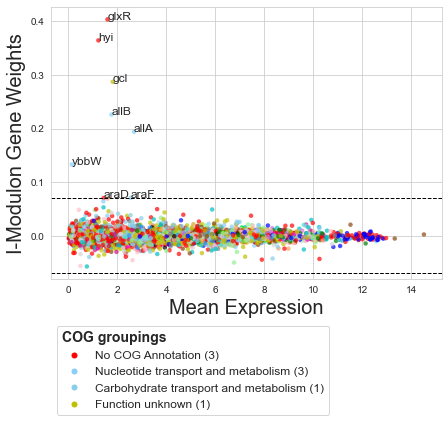

In [8]:
plot_genes(precise2, COMPONENT_NAME, labels=True, adjust=False)

[(<matplotlib.axes._subplots.AxesSubplot at 0x12428b850>,
  <matplotlib.axes._subplots.AxesSubplot at 0x1244676d0>)]

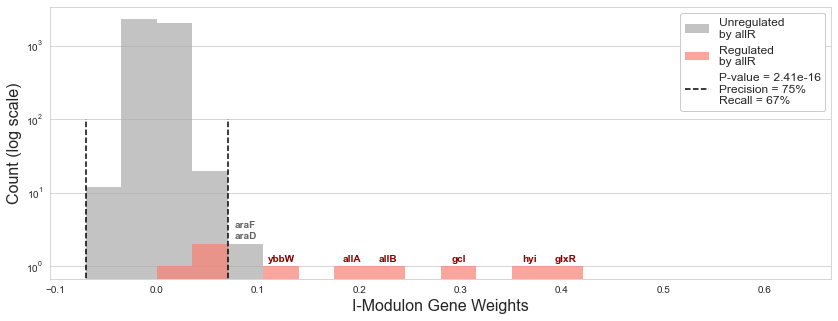

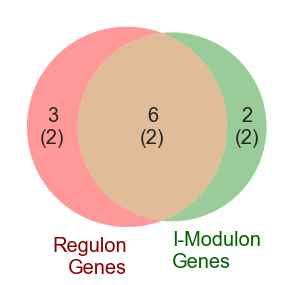

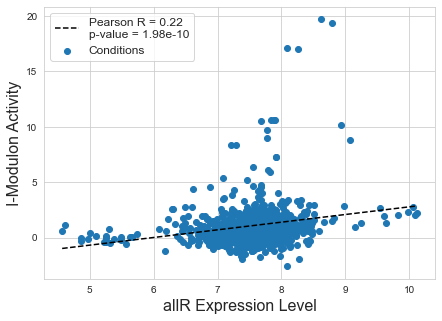

In [9]:
plot_regulon(precise2, COMPONENT_NAME)

In [821]:
genes = precise2.show_enriched(COMPONENT_NAME).index
all_genes = precise2.X.index
enrich_df = compute_enrichments(genes, all_genes, precise2.trn, max_tfs = 2, fdr_rate=1e-5)
enrich_df

,log_odds,pvalue,recall,precision,TP,qvalue,f1score,n_tf


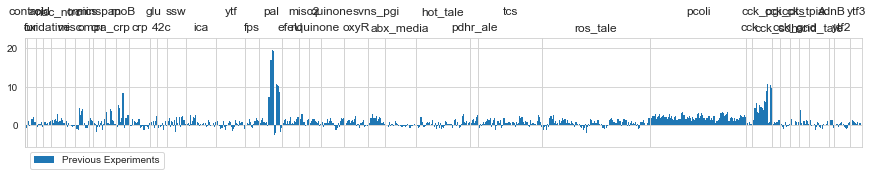

In [10]:
plot_samples_bar(precise2, COMPONENT_NAME)